In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

In [86]:
df = pd.read_csv('../data/Netflix Dataset.csv')

In [87]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


### CHECK IF WE HAVE GPU

In [88]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### DATA CORRECTION AND MODIFICATION

In [89]:
df[["year", "month", "dates"]] = df["Date"].str.split("-", expand = True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,dates
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,2002,05,23
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,2002,05,24
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,2002,05,28
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800,2002,05,29
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200,2002,05,30


In [90]:
df.shape

(5540, 10)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5540 entries, 0 to 5539
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5540 non-null   object 
 1   Open       5540 non-null   float64
 2   High       5540 non-null   float64
 3   Low        5540 non-null   float64
 4   Close      5540 non-null   float64
 5   Adj Close  5540 non-null   float64
 6   Volume     5540 non-null   int64  
 7   year       5540 non-null   object 
 8   month      5540 non-null   object 
 9   dates      5540 non-null   object 
dtypes: float64(5), int64(1), object(4)
memory usage: 432.9+ KB


# DATA CATELOG

### DATA COLS
- Close : The closing price of Netflix stock on the given day.
- High : The highest price of Netflix stock during the trading day.

## EDA

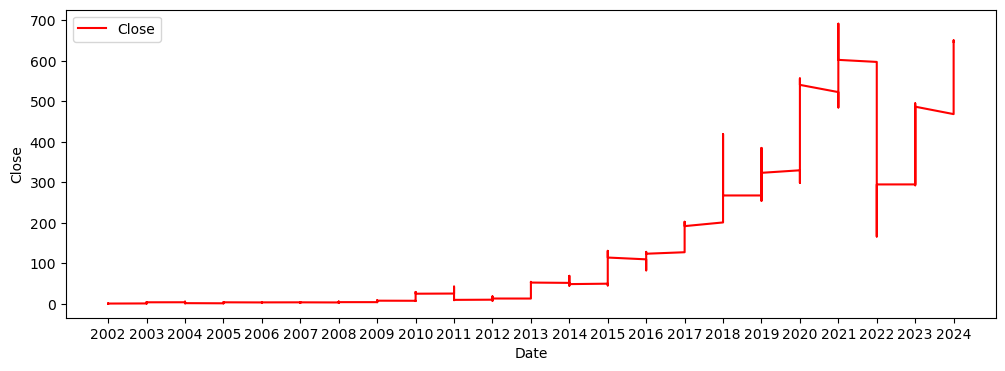

In [92]:
colors = ['red'] 
plt.figure(figsize=(12, 4))  # Adjust the size as needed
plt.plot(df['year'], df['Close'], color=colors[0], label="Close")
plt.xlabel('Date', fontsize=10)  # Corrected x-axis label function
plt.ylabel("Close", fontsize=10)  # Assuming col is defined elsewhere
plt.legend() # Add a legend for each subplot
plt.show() # Show the plot

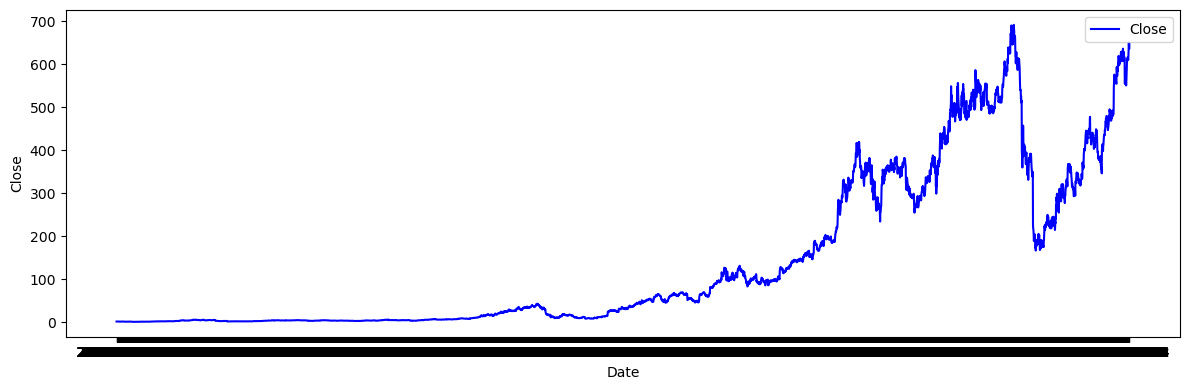

In [93]:
# Assuming df and col are defined elsewhere
colors = ['blue'] 
plt.figure(figsize=(12, 4))  # Adjust the size as needed
plt.plot(df['Date'], df['Close'], color=colors[0], label="Close")
plt.xlabel('Date')  
plt.ylabel("Close")
plt.legend() 
plt.tight_layout() 
plt.show()

We can clearly see that stocks were flat for couple of years so we will exculde that data in order to predict correctly and better EDA. You can do same steps on complete dta but wont get accuracy.

New DATAFrame

In [94]:
df = df.tail(2500)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,dates
3040,2014-06-20,63.028572,63.268570,62.139999,62.882858,62.882858,13222300,2014,06,20
3041,2014-06-23,62.765713,63.122856,62.221428,62.788570,62.788570,10672900,2014,06,23
3042,2014-06-24,62.578571,64.277145,62.214287,62.337143,62.337143,20367200,2014,06,24
3043,2014-06-25,62.142857,63.537144,61.904285,63.458572,63.458572,15752100,2014,06,25
3044,2014-06-26,62.970001,63.162857,62.392857,62.801430,62.801430,14237300,2014,06,26


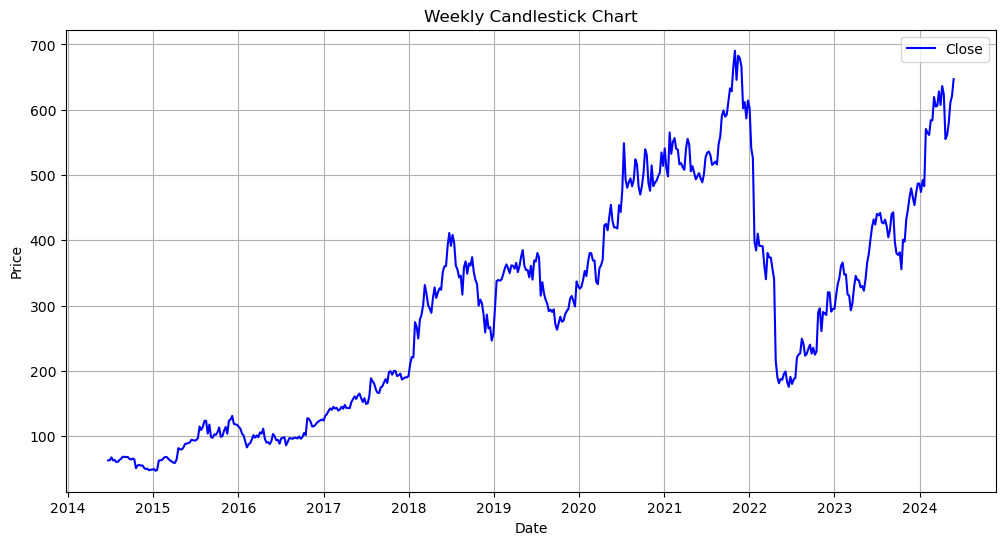

In [95]:
import matplotlib.pyplot as plt

df1= df.copy()
df1.index = pd.to_datetime(df.Date)

# Assuming your DataFrame has columns: 'Date', 'Open', 'High', 'Low', 'Close'
# And 'Date' is in datetime format and is your index

# Resample the data to weekly frequency
weekly_df = df1.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(weekly_df.index, weekly_df['Close'], color='blue', label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Weekly Candlestick Chart')
plt.legend()
plt.grid(True)
plt.show()



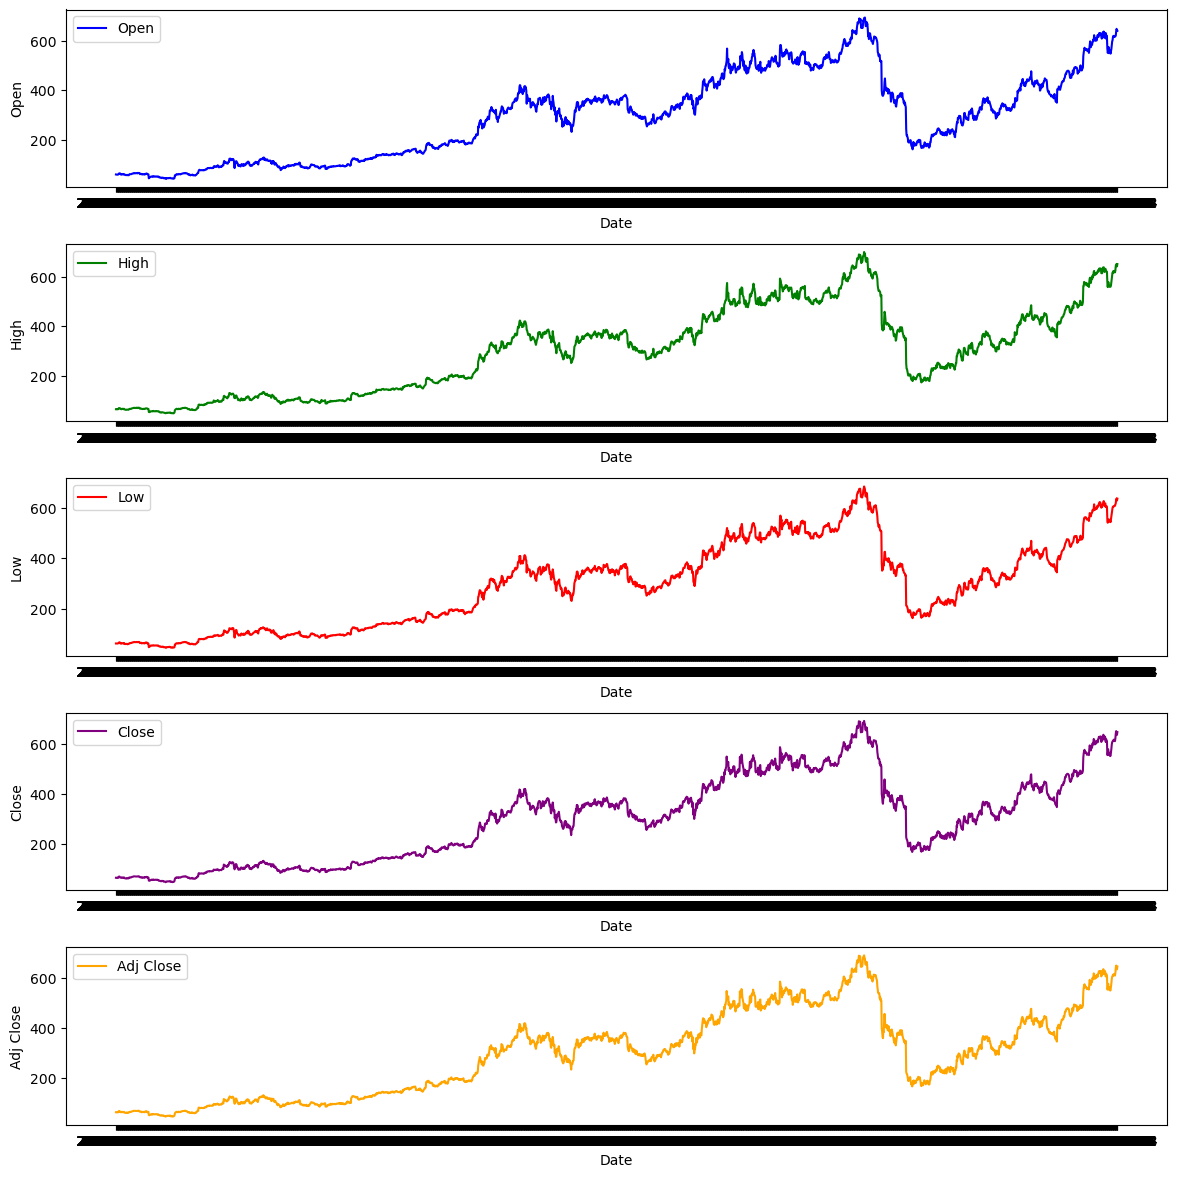

In [96]:

# Create subplots with adjusted figure size
fig, axes = plt.subplots(5, 1, figsize=(12, 12))

# Customize spacing for better readability
fig.tight_layout(pad=2.0)

# Define a color palette for visual distinction (you can customize this)
colors = ['blue', 'green', 'red', 'purple', 'orange'] 

# Iterate through columns and create plots
for index, col in enumerate(df.columns[1:6]):
    axes[index].plot(df['Date'], df[col], color=colors[index], label=col)
    axes[index].set_xlabel('Date', fontsize=10)  # Adjust font size as needed
    axes[index].set_ylabel(col, fontsize=10)
    axes[index].legend() # Add a legend for each subplot
    fig.show() # Show each plot individually within the loop 

## Moving Averages

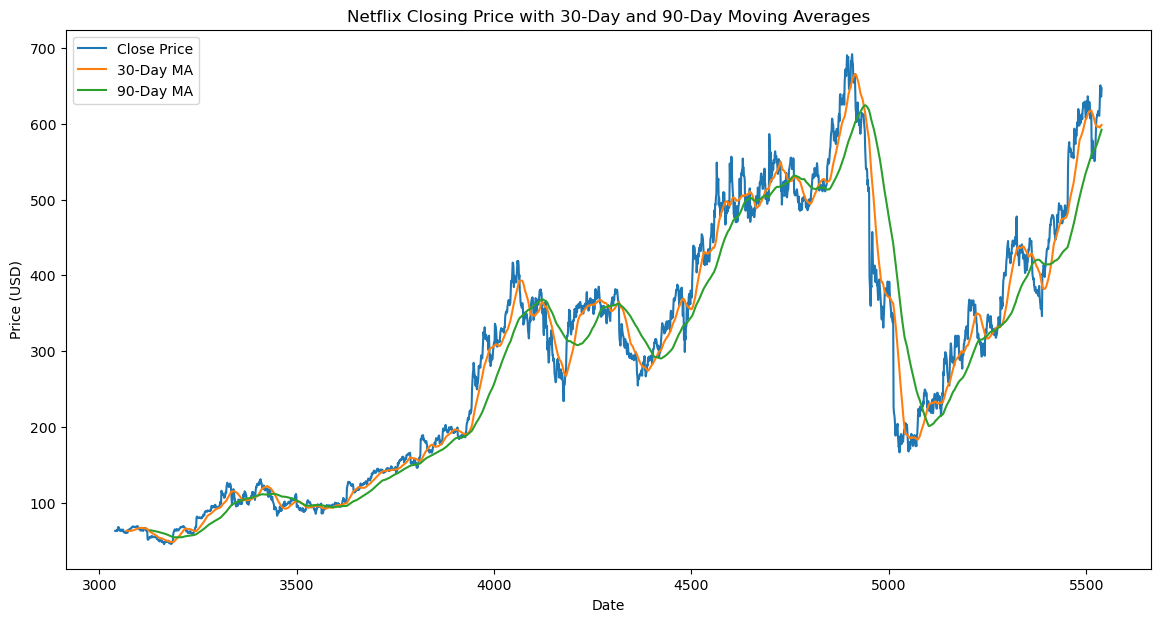

In [97]:
# Calculate moving averages
df['MA30'] = df['Close'].rolling(window=30).mean()
df['MA90'] = df['Close'].rolling(window=90).mean()

# Plot closing price with moving averages
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA30'], label='30-Day MA')
plt.plot(df['MA90'], label='90-Day MA')
plt.title('Netflix Closing Price with 30-Day and 90-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(False)
plt.show()

## VOLUME ANALYSIS

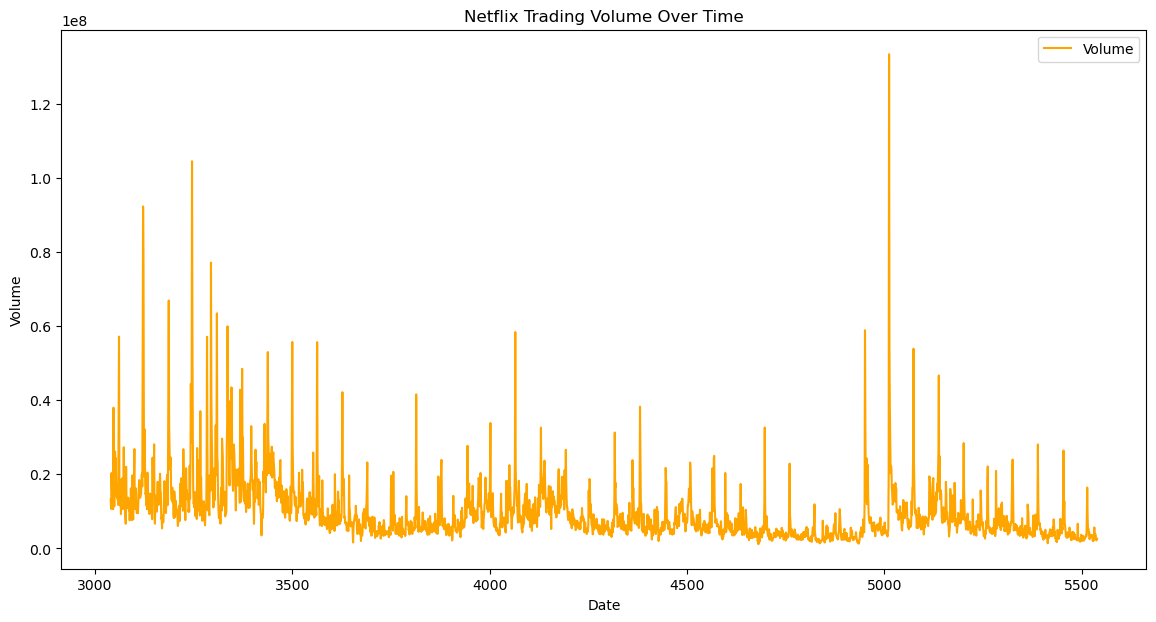

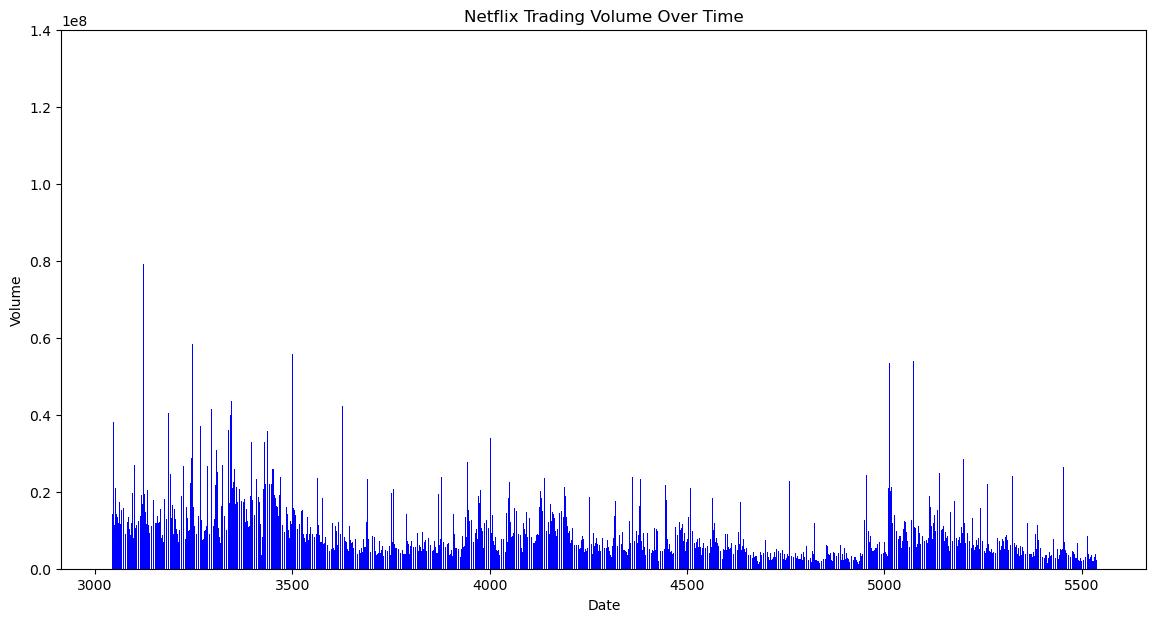

In [98]:
# Plot trading volume over time
plt.figure(figsize=(14, 7))
plt.plot(df['Volume'], label='Volume', color='orange')
plt.title('Netflix Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(False)
plt.show()
# Plot a bar chart of trading volume over time
plt.figure(figsize=(14, 7))
plt.bar(df.index, df['Volume'], color='blue')
plt.title('Netflix Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


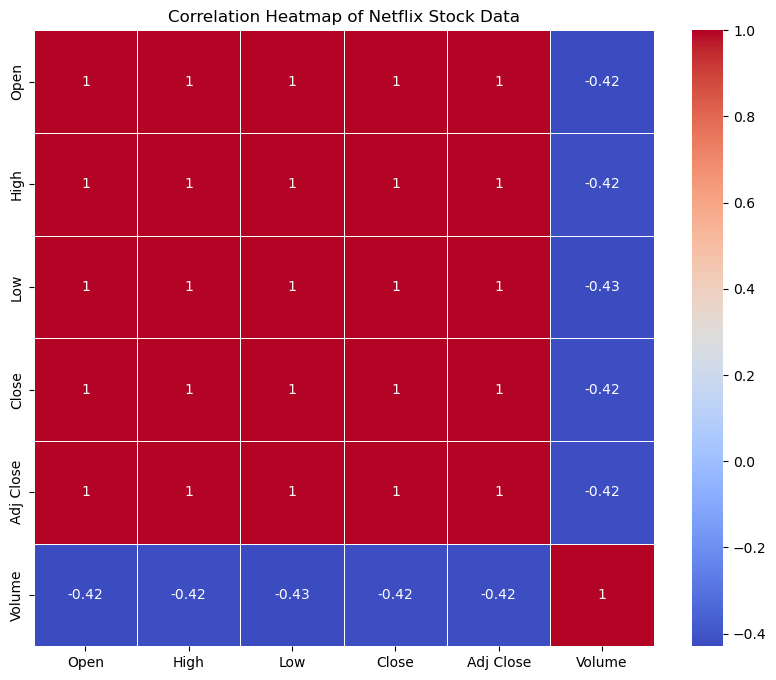

In [99]:
import seaborn as sns

# Calculate correlation matrix
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Netflix Stock Data')
plt.show()

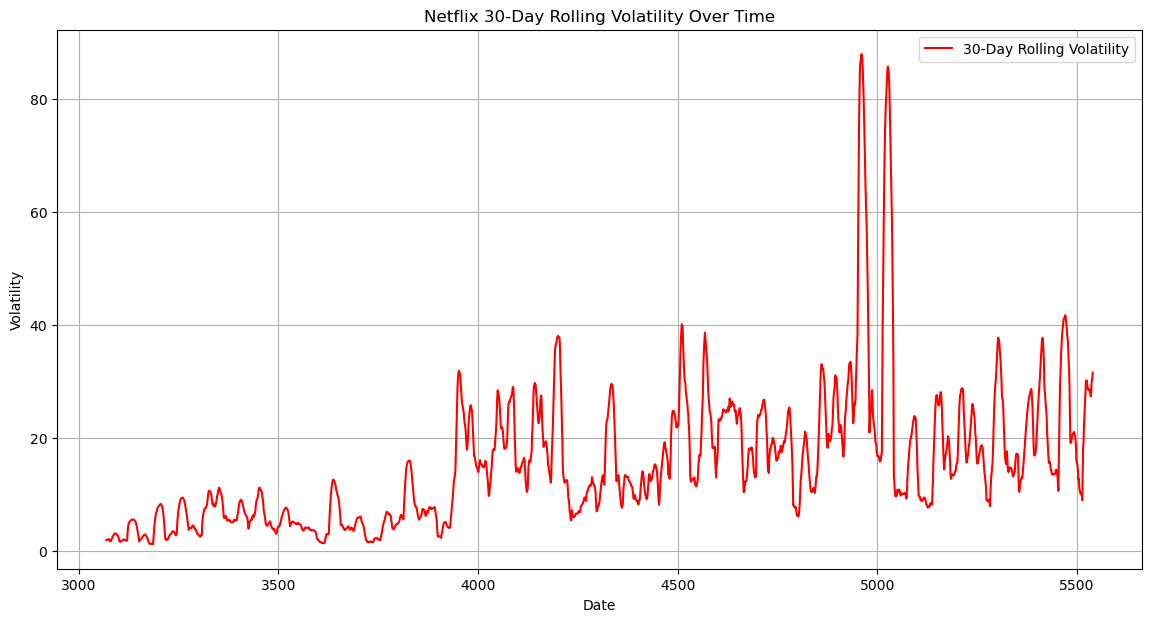

In [100]:
# Calculate rolling standard deviation (volatility)
df['Volatility'] = df['Close'].rolling(window=30).std()

# Plot volatility over time
plt.figure(figsize=(14, 7))
plt.plot(df['Volatility'], label='30-Day Rolling Volatility', color='red')
plt.title('Netflix 30-Day Rolling Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

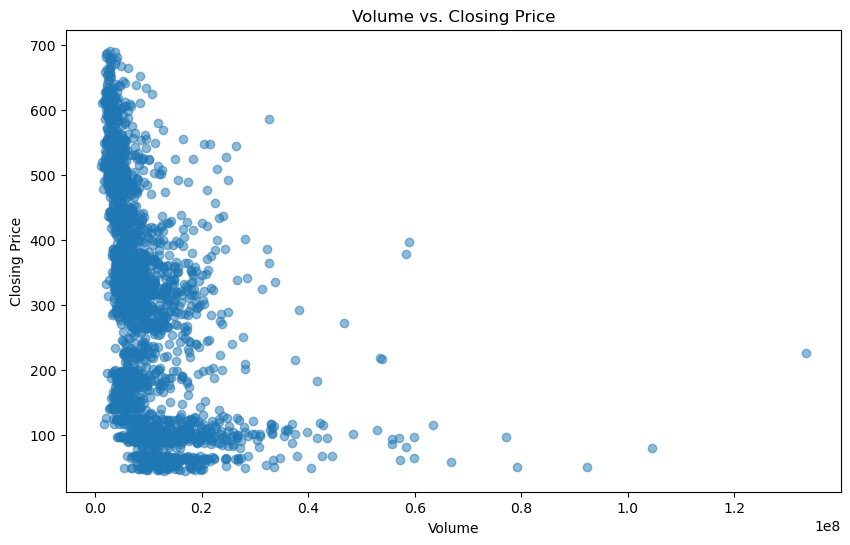

In [101]:
# Scatter Plot: Volume vs. Closing Price
plt.figure(figsize=(10, 6))
plt.scatter(df['Volume'], df['Close'], alpha=0.5)
plt.title('Volume vs. Closing Price')
plt.xlabel('Volume')
plt.ylabel('Closing Price')
plt.show()

## CLOSING PRICE DISTRIBUTION

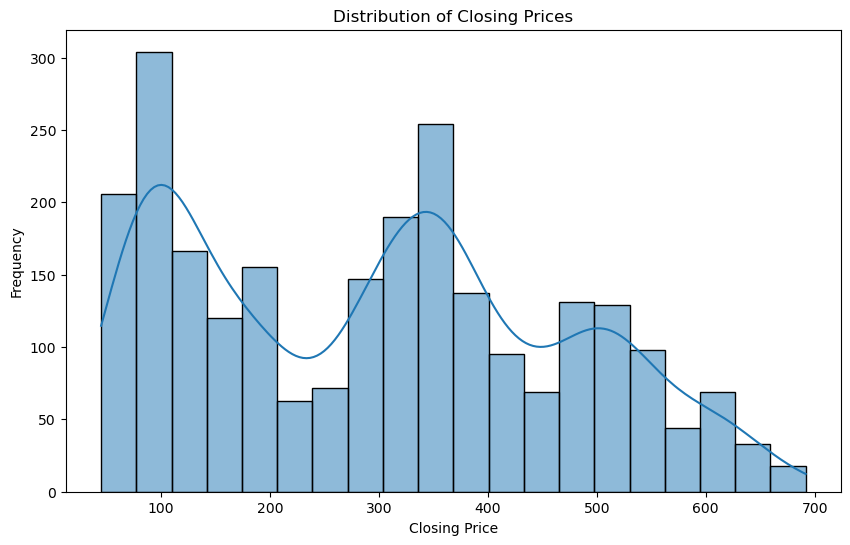

In [102]:
# Histogram: Distribution of Closing Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True, bins=20)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

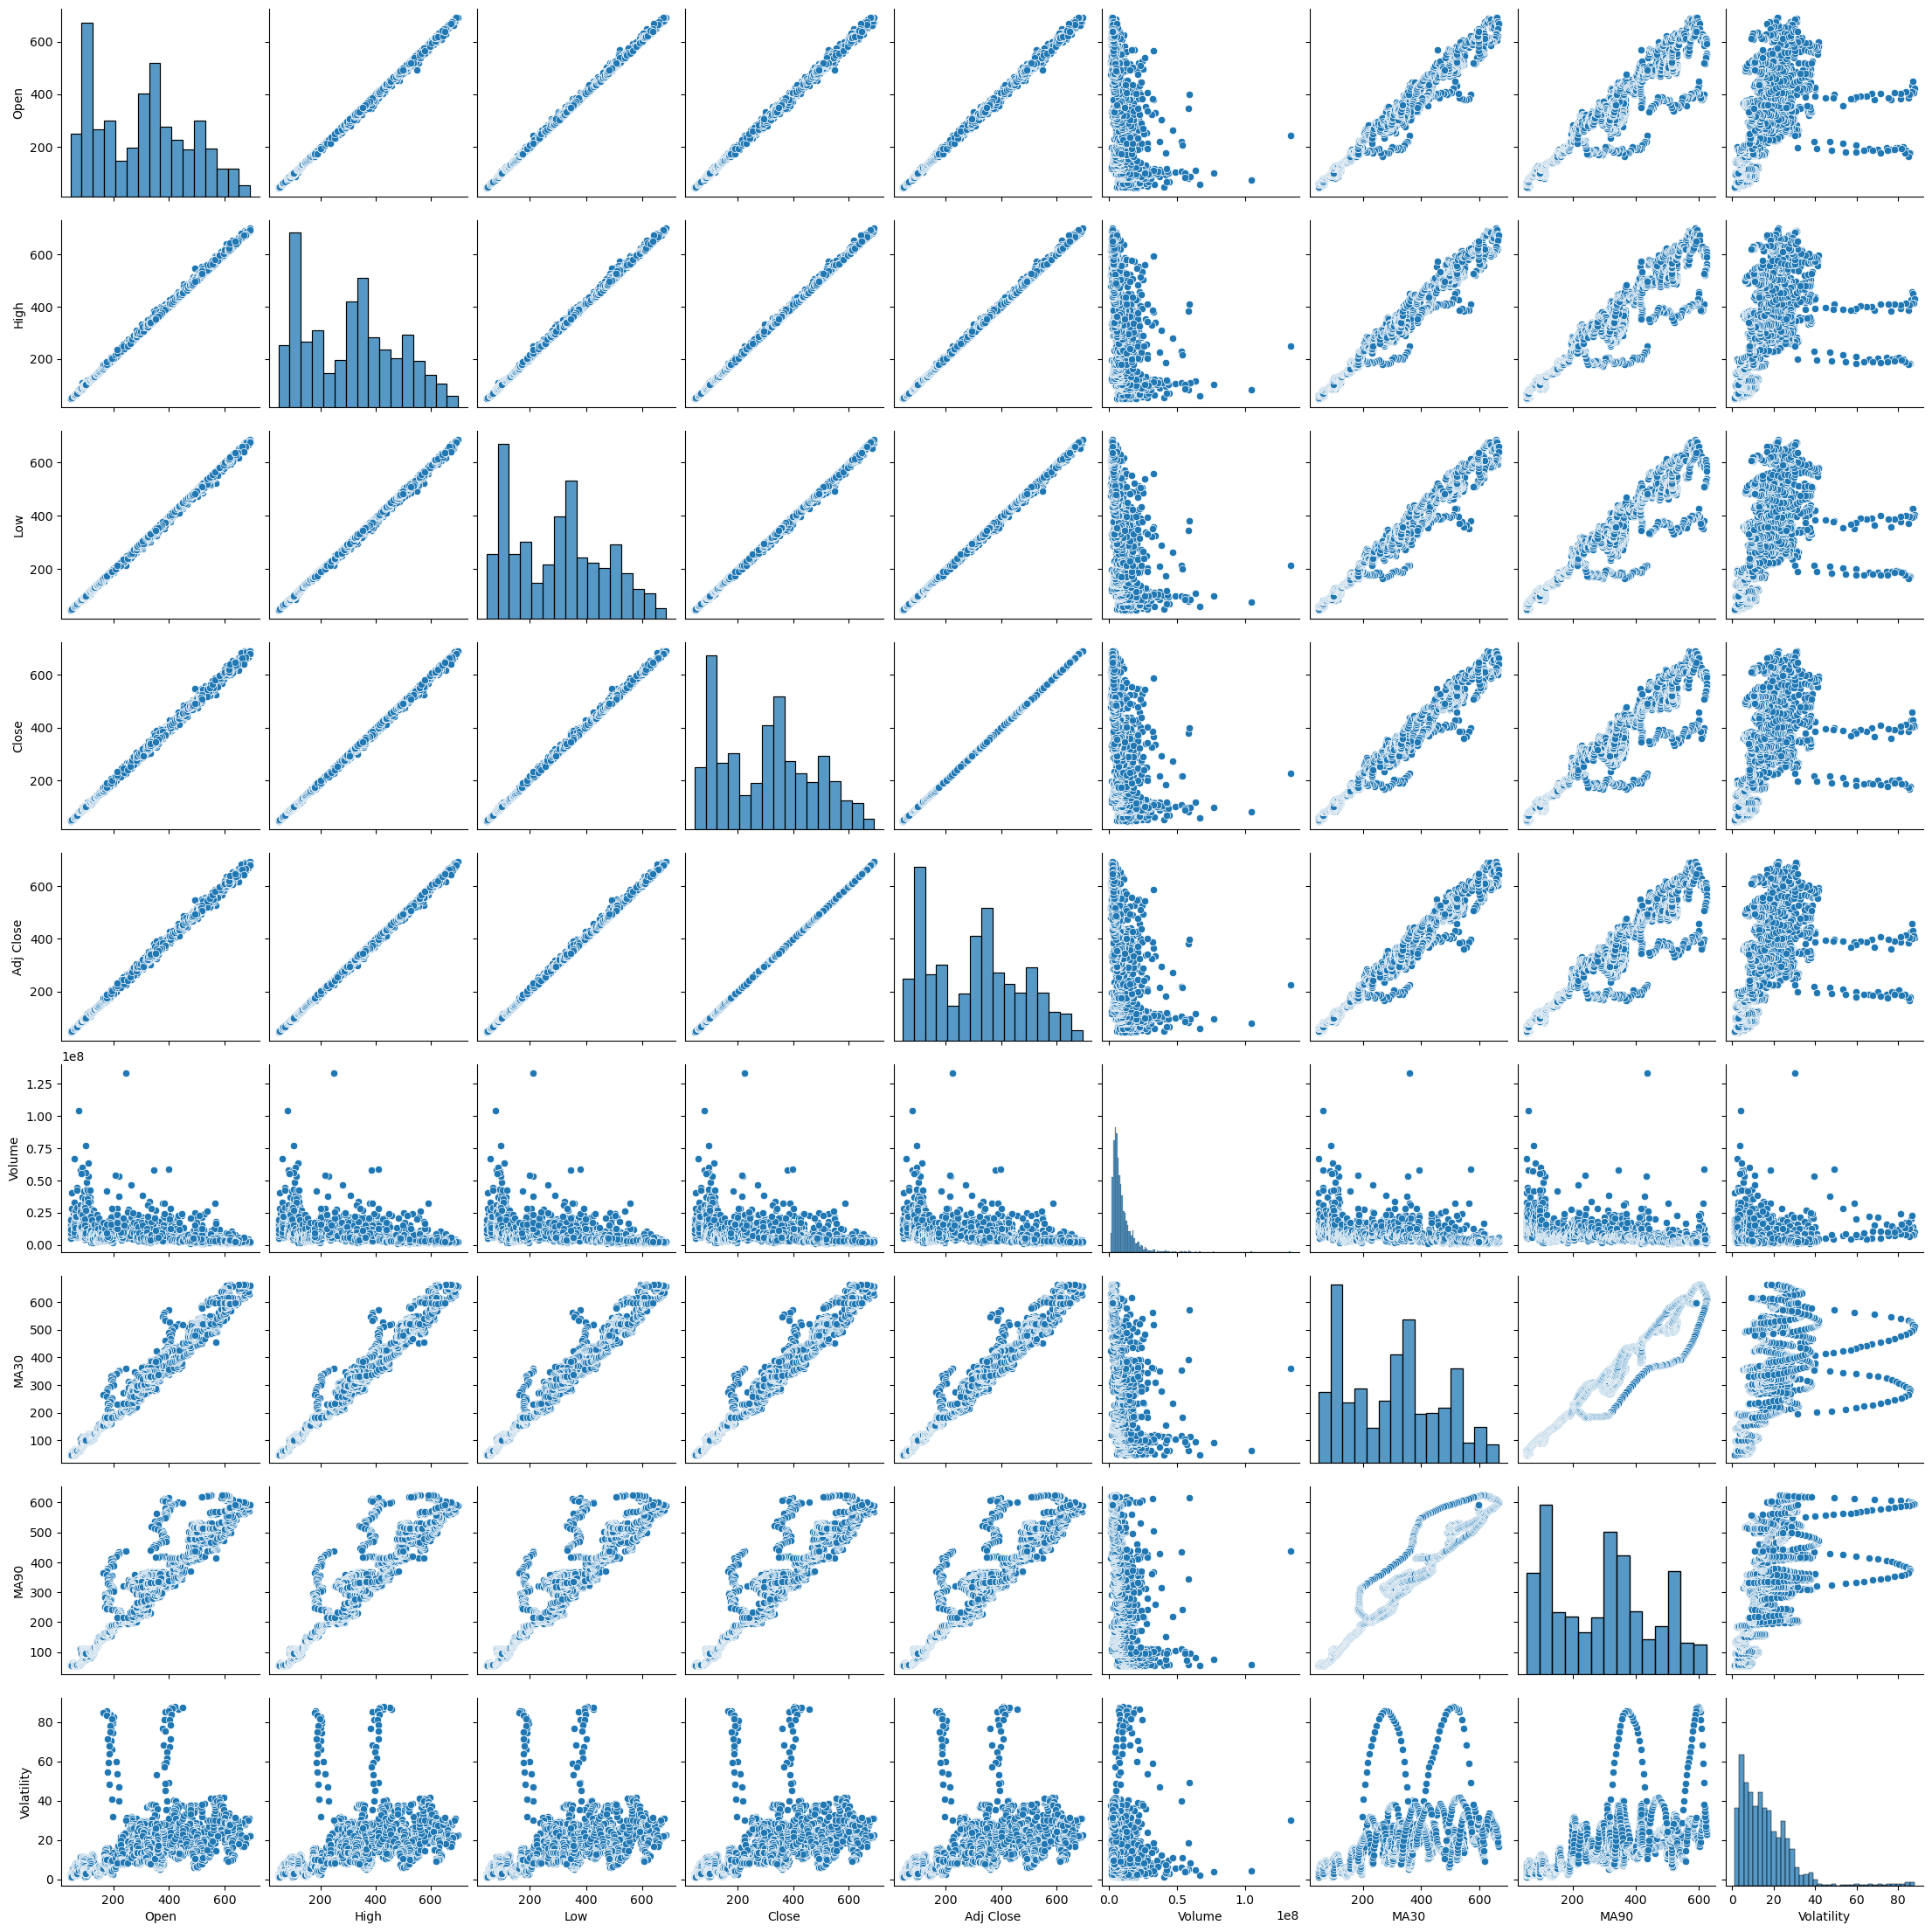

In [103]:
# Pair Plot: Relationships between all numerical columns
sns.pairplot(df.dropna())
plt.show()

In [104]:
df[df['Close'] <= 0.9 ]

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,dates,MA30,MA90,Volatility


<Figure size 700x300 with 0 Axes>

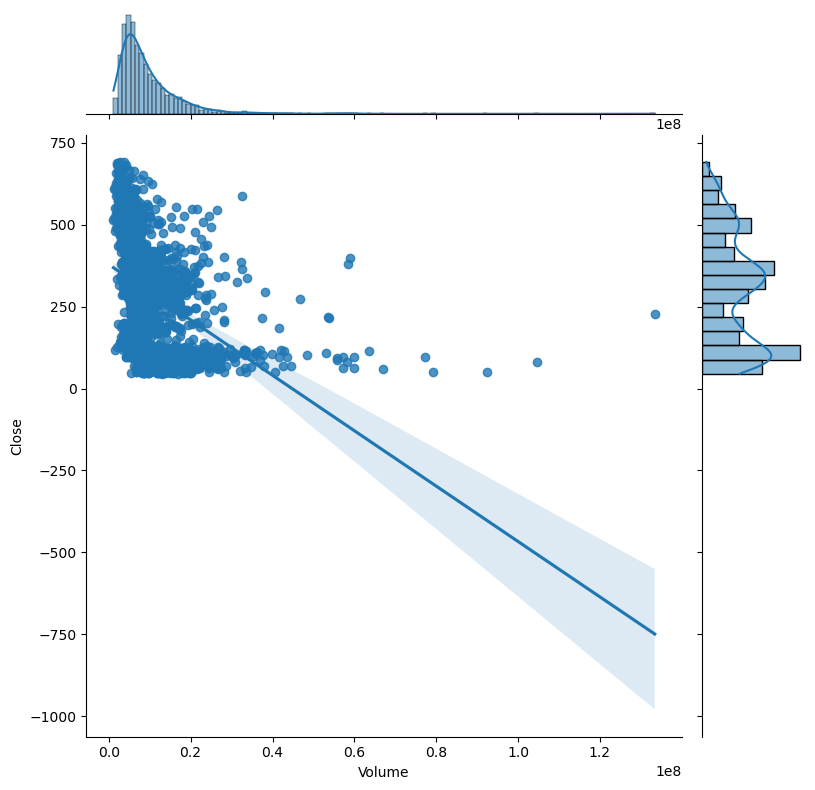

In [105]:
# Joint Plot: Volume vs. Closing Price with regression line
plt.figure(figsize=(7, 3))
sns.jointplot(x='Volume', y='Close', data=df, kind='reg', height=8)
plt.show()

In [106]:
df.drop(columns=['Open', 'Close', 'High', 'Low', 'Volume','MA30' ,'MA90', 'Volatility', 'year', 'month', 'dates'], inplace=True)
df.head()

,Date,Adj Close
3040,2014-06-20,62.882858
3041,2014-06-23,62.788570
3042,2014-06-24,62.337143
3043,2014-06-25,63.458572
3044,2014-06-26,62.801430


In [107]:
scaler = MinMaxScaler(feature_range=(-1, 1))
model=scaler.fit(df['Adj Close'].values.reshape(-1,1))
df['Adj Close']=model.transform(df['Adj Close'].values.reshape(-1,1))
df.head()

,Date,Adj Close
3040,2014-06-20,-0.945313
3041,2014-06-23,-0.945605
3042,2014-06-24,-0.947001
3043,2014-06-25,-0.943532
3044,2014-06-26,-0.945565


In [108]:
df["Adj Close"].values.reshape(-1,1)

array([[-0.945313  ],
       [-0.94560469],
       [-0.94700125],
       ...,
       [ 0.84154284],
       [ 0.82669333],
       [ 0.86097109]])

In [109]:
# function to create train, test data given stock data and sequence length
# we are predicting future so last portion of our data will be recorded as the test dataset example 50000 datapoints last 10k rakhlo future ka lia
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    print("len(data_raw): ",len(data_raw))
    
    # create all possible sequences of length look_back
    # we will take data example 0 to 60 then 1 to 61 then 2 to 62 ------ window size 
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index:index + look_back])
    #print(data[0:3])
    data = np.array(data)
    print("data.shape: ", data.shape)

    test_set_size = int(np.round(0.2*data.shape[0])) #20percent for test
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length # window size
x_train, y_train, x_test, y_test = load_data(df[["Adj Close"]], look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)

print('y_test.shape = ',y_test.shape)

len(data_raw):  2500
data.shape:  (2440, 60, 1)
x_train.shape =  (1952, 59, 1)
y_train.shape =  (1952, 1)
x_test.shape =  (488, 59, 1)
y_test.shape =  (488, 1)


In [110]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [111]:
import torch
import torch.nn as nn


# Build model
input_dim = 1
hidden_dim = 100
num_layers = 2
output_dim = 1

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #.detach() is a PyTorch method that creates a new tensor that does not require gradients. 
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())

# Example forward pass
x_example = torch.randn(10, 5, input_dim).to(device)  # Example input tensor
output_example = model(x_example)
print(output_example)

tensor([[0.1142],
        [0.1153],
        [0.1160],
        [0.1150],
        [0.1150],
        [0.1147],
        [0.1147],
        [0.1158],
        [0.1156],
        [0.1158]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [112]:
model.to(device)

LSTM(
  (lstm): LSTM(1, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [113]:
num_epochs = 500
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Forward pass
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.09299720078706741
Epoch  20 MSE:  0.011740521527826786
Epoch  30 MSE:  0.011354287154972553
Epoch  40 MSE:  0.003297174349427223
Epoch  50 MSE:  0.0024194936268031597
Epoch  60 MSE:  0.001620215130969882
Epoch  70 MSE:  0.0015166986268013716
Epoch  80 MSE:  0.0014343180228024721
Epoch  90 MSE:  0.0013655315851792693
Epoch  100 MSE:  0.0013299226993694901
Epoch  110 MSE:  0.001303740544244647
Epoch  120 MSE:  0.0012804657453671098
Epoch  130 MSE:  0.0012585268123075366
Epoch  140 MSE:  0.0012375216465443373
Epoch  150 MSE:  0.001217217417433858
Epoch  160 MSE:  0.0011975959641858935
Epoch  170 MSE:  0.001178382313810289
Epoch  180 MSE:  0.0011596566764637828
Epoch  190 MSE:  0.0011414791224524379
Epoch  200 MSE:  0.0011238142615184188
Epoch  210 MSE:  0.0011065962025895715
Epoch  220 MSE:  0.0010899691842496395
Epoch  230 MSE:  0.0010739747667685151
Epoch  240 MSE:  0.0010584399569779634
Epoch  250 MSE:  0.0010435355361551046
Epoch  260 MSE:  0.0010292268125340343
Epoc

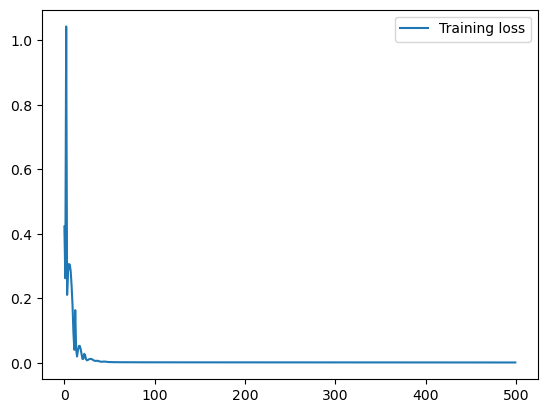

In [114]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [115]:
x_test = x_test.to(device)
y_test_pred = model(x_test)

In [116]:
y_test_pred = y_test_pred.cpu().detach().numpy()
y_test= y_test.cpu().detach().numpy()
x_train= x_train.cpu().detach().numpy()
x_test= x_test.cpu().detach().numpy()
y_train= y_train.cpu().detach().numpy()

In [117]:
y_test_pred.shape, y_test.shape

((488, 1), (488, 1))

In [118]:
from sklearn.metrics import r2_score 
r2 = r2_score(y_test_pred, y_test) 
print('r2 score for perfect model is', r2) 

r2 score for perfect model is 0.9926315982030378


In [119]:
# Inverse transform y_test_pred and y_test
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

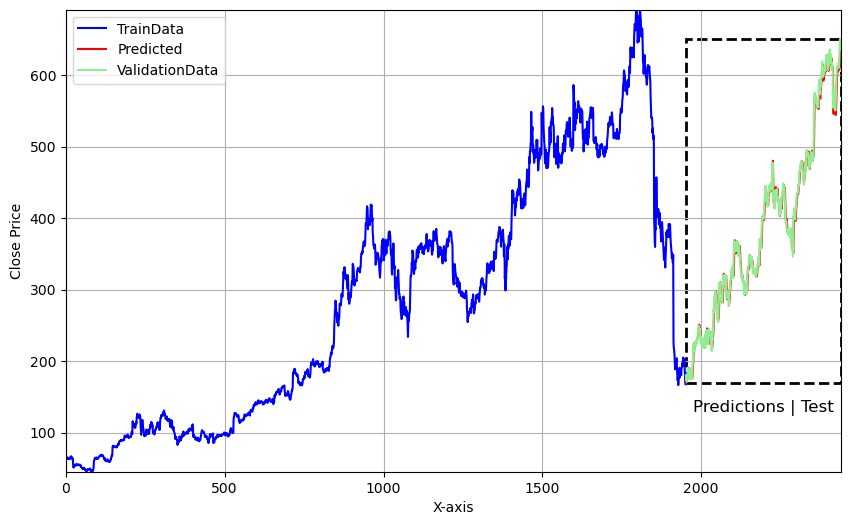

In [120]:
import matplotlib.patches as patches

# Assuming y_train, y_test_pred, and y_test are already defined
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Plot y_train with a different color
plt.plot(range(len(y_train)), y_train, label='TrainData', color='blue')  

# Plot y_test_pred and y_test with different colors
plt.plot(range(len(y_train), len(y_train) + len(y_test_pred)), y_test_pred, label='Predicted', color='red')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='ValidationData', color='lightgreen')

# Set the y-axis limits based on the minimum and maximum values of both arrays
plt.ylim(min(y_train.min(), y_test_pred.min(), y_test.min()), max(y_train.max(), y_test_pred.max(), y_test.max()))

# Set the x-axis limits
plt.xlim(0, len(y_train) + len(y_test))

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Close Price')

# Display the legend
plt.legend()

# Add a square around the y_test_pred
ax = plt.gca()
rect = patches.Rectangle((len(y_train), min(y_test_pred.min(), y_test.min())), len(y_test_pred), 
                         max(y_test_pred.max(), y_test.max()) - min(y_test_pred.min(), y_test.min()), 
                         linewidth=2, edgecolor='black', facecolor='none', linestyle='--')
ax.add_patch(rect)

# Add text label to the rectangle
plt.text(len(y_train) + len(y_test_pred) / 2, min(y_test_pred.min(), y_test.min()) - 0.05 * (max(y_test_pred.max(), y_test.max()) - min(y_test_pred.min(), y_test.min())), 
         'Predictions | Test', horizontalalignment='center', verticalalignment='top', fontsize=12, color='black')

# Show the plot
plt.grid(True)  # Add a grid if desired
plt.show()